In [1]:
from skimage.restoration import estimate_sigma, denoise_wavelet
from skimage.util import random_noise
import cv2
import torch 
import numpy as np
import os
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display
from ipyfilechooser import FileChooser
import json
from pathlib import Path
import scipy.ndimage as ndi
from skimage.restoration import denoise_wavelet, estimate_sigma
import torchvision 
import torchvision.transforms as T 
import torchvision.transforms.functional as F 
from torchvision.io import read_image 
import torchvision.transforms as transforms
from PIL import Image

%matplotlib notebook

In [2]:
# Contrast and Brightness
# Contrast: < 1.0 >
def adjust_contrast(image, contrast):
    new_image = np.int16(image)
    new_image = new_image * contrast
    new_image = np.clip(new_image, 0, 255)
    new_image = np.uint8(new_image)
    return new_image

# Brightness
# 0 - 255
# brightness value would be the amount to increase or decrease each pixel value
def adjust_brightness(image, brightness=0):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # Limit values to 255, no overflow
    lim = 255 - brightness
    v[v > lim] = 255
    v[v <= lim] += brightness

    hsv_new = cv2.merge((h, s, v))
    return cv2.cvtColor(hsv_new, cv2.COLOR_HSV2BGR)


# Gamma
# < 1.0 >
def adjust_gamma(image, gamma=1.0):
    table = []
    for i in np.arange(0, 256):
        i /= 255.0
        i **= 1.0 / gamma
        table.append(i * 255.0)
    table = np.array(table, dtype=np.uint8)

    return cv2.LUT(image, table)

def adjust_cliplimit(image, cliplimit=1.0, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=tileGridSize)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(image)
    L = clahe.apply(L)
    image = cv2.cvtColor(cv2.merge((L, A, B)), cv2.COLOR_LAB2BGR)
    return image

# Saturation
def adjust_saturation(image, saturation = 0):
    
    cvImg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensorImg = transforms.ToTensor()(cvImg)
    pic = F.adjust_saturation(tensorImg, saturation) 
    pic_saturation = T.ToPILImage()(pic)

    numpy_image=np.array(pic_saturation)  
    pic_saturation=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR) 
    
    return pic_saturation

def adjust_unsharpmask(image, strength=0.0, sigma=1.0, kernel_size=(5,5)):
    # Ignore small amounts
    if strength < 0.5:
        return image
    
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)  
    sharpened = float(strength + 1) * image - float(strength) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))  

    return sharpened.round().astype(np.uint8)

# Denoise
def adjust_denoise(image, denoise):
    # Ignore small denoise as no change
    if denoise == 0:
        return image
    
    image = image.astype('float32') / 255
    
    # Estimate noise standard deviation
    sigma_est = estimate_sigma(image, channel_axis=-1, average_sigmas=True)

    # Denoise the image
    denoised = denoise_wavelet(image, channel_axis=-1, convert2ycbcr=True,
                               method='VisuShrink', mode='soft',
                               sigma=sigma_est / denoise, rescale_sigma=True)

    # Clip pixel values to the valid range
    noisy_image = np.clip(image, 0, 1)
    denoised = np.clip(denoised, 0, 1)
    denoised = (denoised * 255.0).astype('uint8')
    
    return denoised

In [4]:
def load_image():
    global image, image_path, image_idx, image_filename
    
    image_filename = image_list[image_idx]
    image_path = os.path.join(image_dir, image_list[image_idx])
    image = cv2.imread(image_path)

def get_new_image():
    global image, new_image, contrast, brightness, gamma
    global cliplimit, strength, denoise, saturation, changes
    
    new_image = image
    new_image = adjust_contrast(image, contrast)
    new_image = adjust_brightness(new_image, brightness)
    new_image = adjust_gamma(new_image, gamma)
    new_image = adjust_cliplimit(new_image, cliplimit)
    new_image = adjust_unsharpmask(new_image, strength)
    new_image = adjust_saturation(new_image, saturation)
    new_image = adjust_denoise(new_image, denoise)
    
def update(value):
    global image, image_plt, contrast, brightness, gamma, cliplimit
    global strength, denoise, saturation, changes
    
    name = value['owner'].description
    if name == 'contrast':
        contrast = value['new']
    elif name == 'brightness':
        brightness = value['new']
    elif name == 'gamma':
        gamma = value['new']
    elif name == 'cliplimit':
        cliplimit = value['new']
    elif name == 'strength':
        strength = value['new']
    elif name == 'saturation':
        saturation = value['new']
    elif name == 'denoise':
        denoise = value['new']

    get_new_image()

    # BGR2RGB for matplotlib compatibility
    image_for_plt = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    image_plt.set_data(image_for_plt)

def save_image_button_action(arg):
    global output_dir, image_filename, new_image
    global json_to_write, contrast, brightness, gamma, cliplimit, strength, saturation, denoise

    properties = {'image_filename': image_filename, 'contrast': contrast, 'brightness': brightness,
                  'gamma': gamma, 'cliplimit': cliplimit, 'strength':strength, 'saturation':saturation,
                  'denoise': denoise}
    json_to_write.append(properties)
    cv2.imwrite(os.path.join(output_dir, image_filename), new_image)

def save_json_button_action(arg):
    global output_json, json_to_write
    # Save to JSON
    with open(output_json, 'w') as f:
        json.dump(json_to_write, f)

def previous_button_action(arg):
    global image_idx, image_plt, image, orig_plt
    image_idx -= 1
    load_image()
    image_for_plt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_plt.set_data(image_for_plt)
    orig_plt.set_data(image_for_plt)

def next_button_action(arg):
    global image_idx, image_idx_total, image_plt, image, orig_plt
    image_idx += 1
    if image_idx <= image_idx_total:
        load_image()
        image_for_plt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_plt.set_data(image_for_plt)
        orig_plt.set_data(image_for_plt)
    else:
        image_idx -= 1
        print('No more images in the directory. Please save JSON')

In [5]:
# Run this block for every new folder

image_dir = 'images'

image_list = os.listdir(image_dir)
image_idx_total = len(image_list)
image_idx = 0
json_to_write = [] # Empty the JSON buffer for new directory
output_json = image_dir + '.json'

output_dir = image_dir + '_out'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

<IPython.core.display.Javascript object>


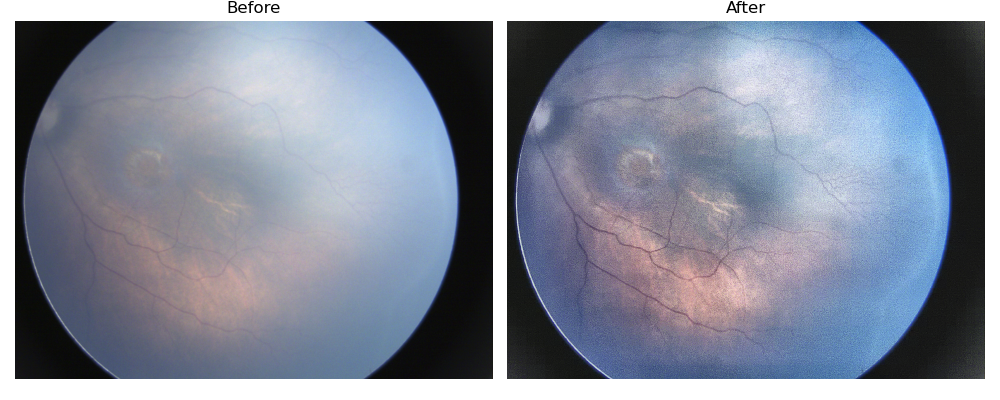

In [6]:
load_image()

image_for_plt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
orig_plt = plt.imshow(image_for_plt)
plt.title('Before')
plt.axis('off')

plt.subplot(1, 2, 2)
image_plt = plt.imshow(image_for_plt)
plt.title('After')
plt.axis('off')
plt.tight_layout()

new_image = image

contrast = 1.0
brightness = 0
gamma = 1.0
cliplimit = 1.0
strength = 1.0
saturation = 1.0
denoise = 0

slider_layout = Layout(width='auto', grid_area='sliders') 
button_layout = Layout(width='auto', grid_area='buttons')


contrast_slider = widgets.FloatSlider(
    description='contrast',
    value=1.0,
    min=0.1, max=3.0, step=0.01,
    layout=slider_layout
)
brightness_slider = widgets.IntSlider(
    description='brightness',
    value=0,
    min=0, max=255, step=1,
    layout=slider_layout
)
gamma_slider = widgets.FloatSlider(
    description='gamma',
    value=1.0,
    min=0.1, max=5.0, step=0.01,
    layout= slider_layout
)
cliplimit_slider = widgets.FloatSlider(
    description='cliplimit',
    value=1.0,
    min=1.0, max=10.0, step=0.1,
    layout= slider_layout
)
strength_slider = widgets.FloatSlider(
    description = 'strength',
    value = 0.0, min = 0.5, max = 10, step = 0.5,
    layout= slider_layout
)
denoise_slider = widgets.FloatSlider(
   description='denoise',
   value=0,
   min= 0, max= 20, step=0.5,
  layout=slider_layout
)
saturation_slider = widgets.FloatSlider(
    description='saturation',
    value= 1.0,
    min=0, max=10, step=0.5,
    layout=slider_layout
)

# Sliders
contrast_slider.observe(update, 'value')
brightness_slider.observe(update, 'value')
gamma_slider.observe(update, 'value')
cliplimit_slider.observe(update, 'value')
strength_slider.observe(update, 'value')
denoise_slider.observe(update, 'value')
saturation_slider.observe(update, 'value')

# Save button
save_image_button = widgets.Button(description = 'Save Image', layout=button_layout)
save_image_button.on_click(save_image_button_action)
save_json_button = widgets.Button(description = 'Save JSON', layout=button_layout)
save_json_button.on_click(save_json_button_action)

# Previous & Next button
previous_button = widgets.Button(description = 'Previous', layout=button_layout)
previous_button.on_click(previous_button_action)
next_button = widgets.Button(description = 'Next', layout=button_layout)
next_button.on_click(next_button_action)

layout = Layout(display='grid', 
               grid_template_columns='70% 30%',
               grid_template_areas='''
                   "sliders buttons"
               ''')

widgets.VBox([
      widgets.VBox([contrast_slider, brightness_slider, gamma_slider, cliplimit_slider,
                    strength_slider, denoise_slider, saturation_slider], layout=slider_layout),
      widgets.VBox([save_image_button, save_json_button, previous_button, next_button], layout=button_layout)
], layout=layout)